# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

In [69]:
from sklearn import datasets
import math
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [70]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [71]:
data = datasets.fetch_california_housing()
data_df = pd.DataFrame(data.data, columns= data.feature_names)
data_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [72]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target,
                                                    test_size = 0.25, random_state = 13)
X_train, X_test, y_train, y_test = X_train.astype(np.float32), X_test.astype(np.float32), \
y_train.astype(np.float32), y_test.astype(np.float32)

In [73]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [75]:
y_train.dtype, y_test.dtype, X_train.dtype, X_test.dtype

(dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'))

In [76]:
def data_prepare_to_torch(X_train, X_test, y_train, y_test):
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    X_test = torch.from_numpy(X_test)
    y_test = torch.from_numpy(y_test)

    train = Data.TensorDataset(X_train, y_train)
    test = Data.TensorDataset(X_test, y_test)
    return train, test
    
    

In [77]:
train, test = data_prepare_to_torch(X_train, X_test, y_train, y_test)

In [78]:
train.tensors[0].shape, test.tensors[0].shape

(torch.Size([15480, 8]), torch.Size([5160, 8]))

In [79]:
train_loader = Data.DataLoader(dataset = train, batch_size = 480, 
                               shuffle = True, num_workers = 1, )
test_loader = Data.DataLoader(dataset = test, batch_size = 100, 
                               shuffle = True, num_workers = 1, )

In [82]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        if self.activation=="sigmoid":
            return F.sigmoid(x)
        if self.activation=="silu":
            return F.silu(x)
        if self.activation=="leakyrelu":
            return F.leaky_relu
        raise RuntimeError

    
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedForward, self).__init__()
        
        #self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 256, "silu")
        
        self.bn2 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(0.33)
        self.fc2 = Perceptron(256, 128, "silu")
        
        self.bn3 = nn.BatchNorm1d(128)
        self.dp3 = nn.Dropout(0.4)
        self.fc3 = Perceptron(128, 64, "silu")
        
        #self.bn4 = nn.BatchNorm1d(64)
        #self.dp4 = nn.Dropout(0.2)
        #self.fc4 = Perceptron(64, 32, "silu")
        
        self.bn5 = nn.BatchNorm1d(64)
        self.dp5 = nn.Dropout(0.33)
        
        self.fc5_pr = Perceptron(64, output_dim)
        
    def forward(self, x):
        #x = self.bn1(x)
        x = self.fc1(x)
        
        x = self.bn2(x)
        x = self.dp2(x)
        x = self.fc2(x)
        
        x = self.bn3(x)
        x = self.dp3(x)
        x = self.fc3(x)
        
        #x = self.bn4(x)
        #x = self.dp4(x)
        #x = self.fc4(x)
        
        x = self.bn5(x)
        x = self.dp5(x)
        
        x = self.fc5_pr(x)
        return x[ : ,0]


In [84]:
def history(optim, model, train_loader, test_loader, num_epoch=40): 
    
    model.train()
    optimizer = optim(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    train_loss_history =[] 
    val_loss_history=[] 
    
    for epoch in range(num_epoch):
        #при каждой эпохе инициализируем параметры лосов 0
        train_loss = 0
        val_loss = 0.0 
        
        for inputs, y in train_loader:
            inputs = inputs.to(device) # передача на устройство видиокарту
            y = y.to(device)
            model_y = model(inputs) # предсказание
            
            loss = criterion(model_y, y)
            
            optimizer.zero_grad() 
            
            loss.backward() 
            optimizer.step()
            
            train_loss += loss.item()
            
            
        else:
            with torch.no_grad(): #проверка вал данных не используем при этом пересчет градиента
                for val_inputs, val_y in test_loader: 
                    val_inputs = val_inputs.to(device) 
                    val_y = val_y.to(device) 
                    val_model_y = model(val_inputs)  
                    
                    v_loss1 = criterion(val_model_y, val_y)    
                    
                    val_loss += v_loss1.item() 
                    
                
        train_loss_history.append(math.log(math.sqrt(train_loss/len(train_loader))))
        val_loss_history.append(math.log(math.sqrt(val_loss/len(test_loader)))) 
    return train_loss_history, val_loss_history

In [86]:
def history_2(optim, model, train_loader, test_loader, num_epoch=40,mode=None,):
    model.train()
    if mode == 'Nesterov':
        optimizer = optim(model.parameters(), nesterov=True, momentum=0.9, lr=0.01)
    elif mode == 'Heavy_ball':
        optimizer = optim(model.parameters(), momentum=0.9, lr=0.01)
    else:
        optimizer = optim(model.parameters(), lr=0.01)
            
        
    criterion = nn.MSELoss()
    train_loss_history =[] 
    val_loss_history =[] 
    
    for epoch in range(num_epoch):
        #при каждой эпохе инициализируем параметры лосов 0
        train_loss = 0
        val_loss = 0.0 
        
        for inputs, y in train_loader:
            inputs = inputs.to(device) # передача на устройство видиокарту
            y = y.to(device)
            model_y = model(inputs) # предсказание
            
            loss = criterion(model_y, y)
            
            optimizer.zero_grad() 
            
            loss.backward() 
            optimizer.step()
            
            train_loss += loss.item()
            
            
        else:
            with torch.no_grad(): #проверка вал данных не используем при этом пересчет градиента
                for val_inputs, val_y in test_loader: 
                    val_inputs = val_inputs.to(device) 
                    val_y = val_y.to(device) 
                    val_model_y = model(val_inputs)  
                    
                    v_loss1 = criterion(val_model_y, val_y)    
                    
                    val_loss += v_loss1.item() 
                    
                
        train_loss_history.append(math.log(math.sqrt(train_loss/len(train_loader))))
        val_loss_history.append(math.log(math.sqrt(val_loss/len(test_loader)))) 
    return train_loss_history, val_loss_history

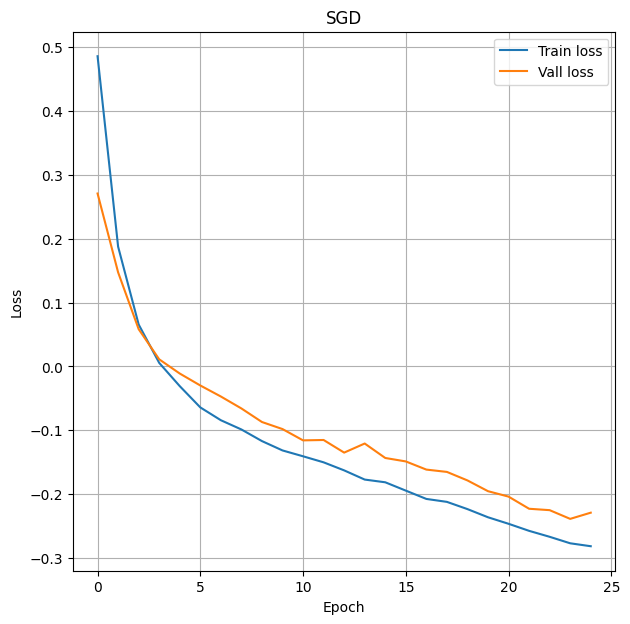

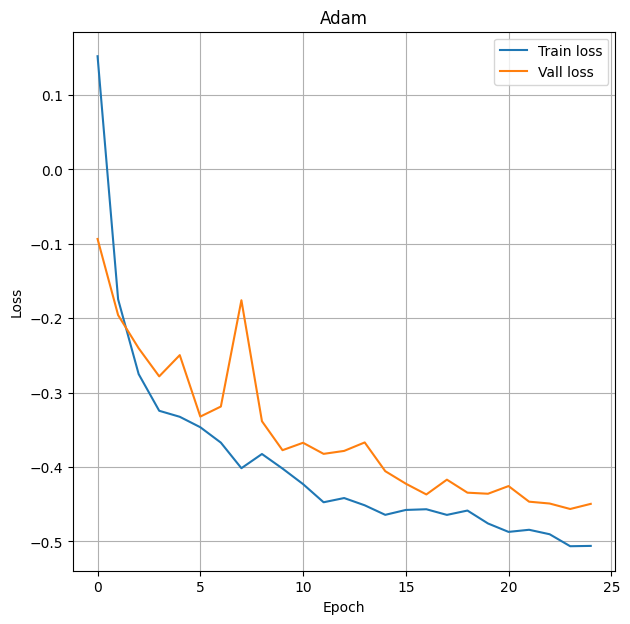

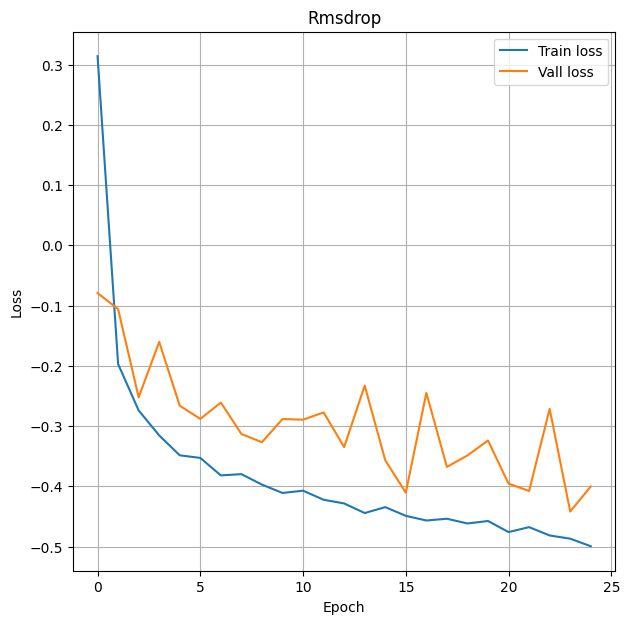

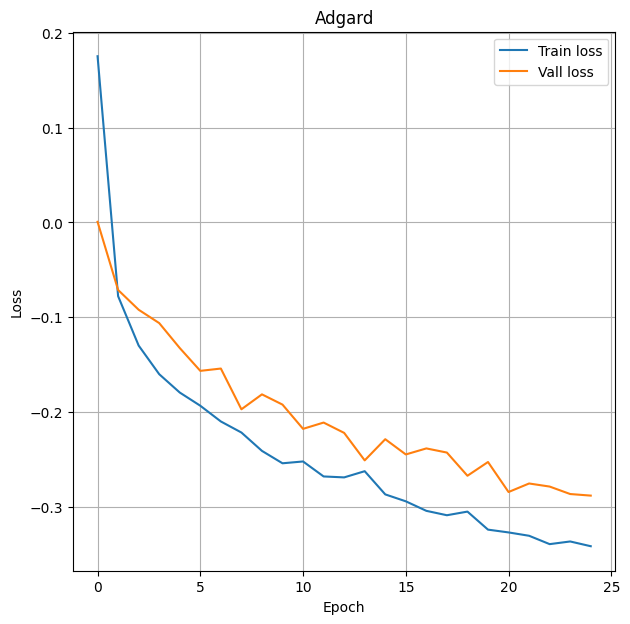

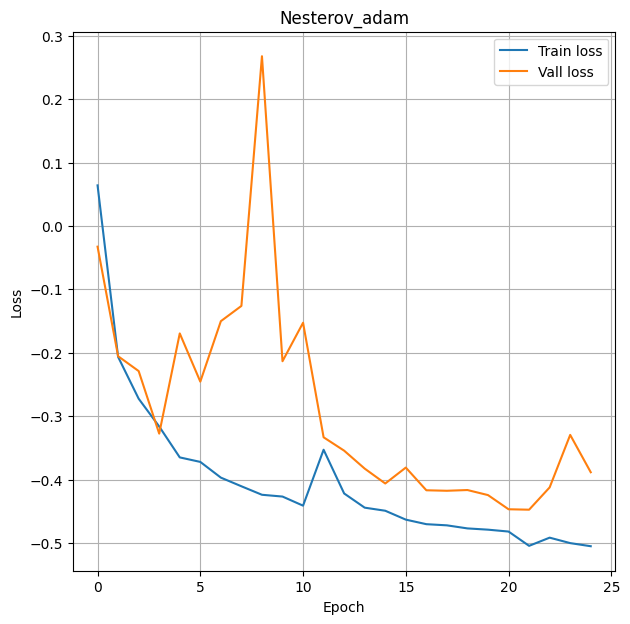

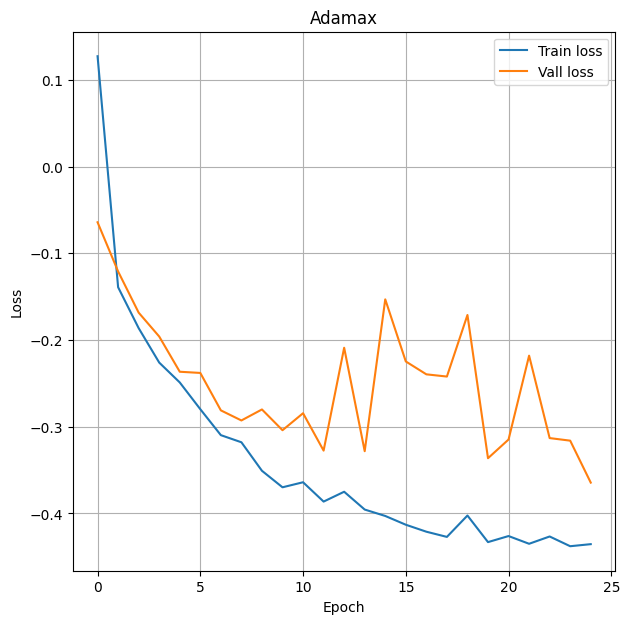

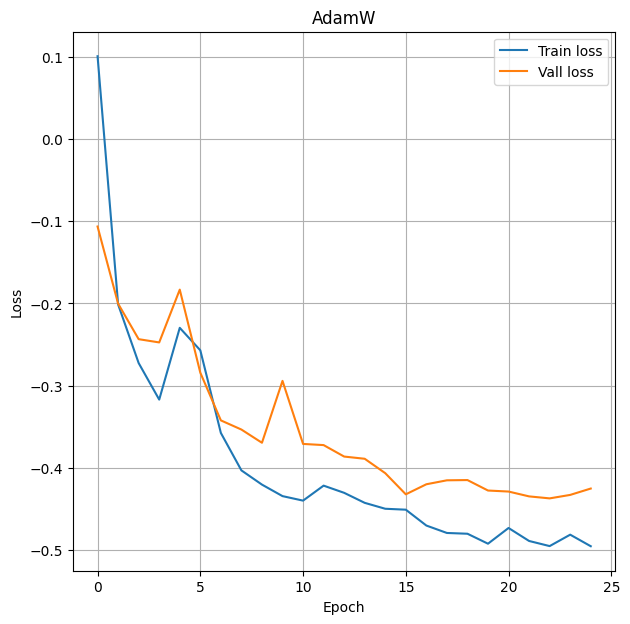

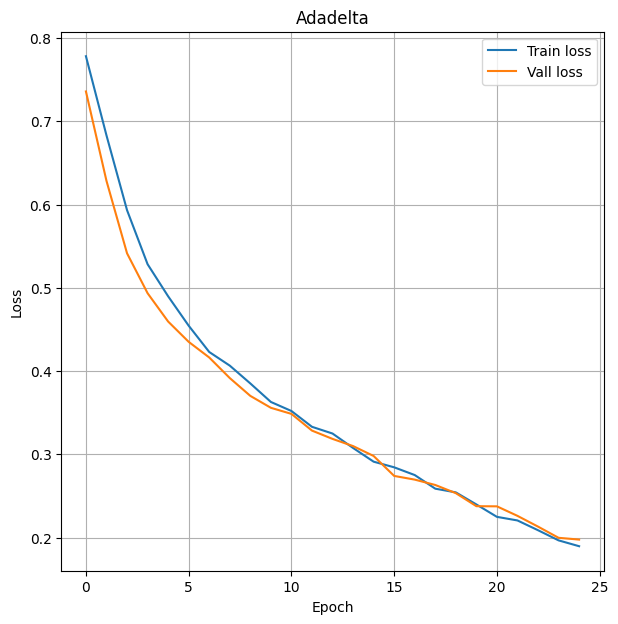

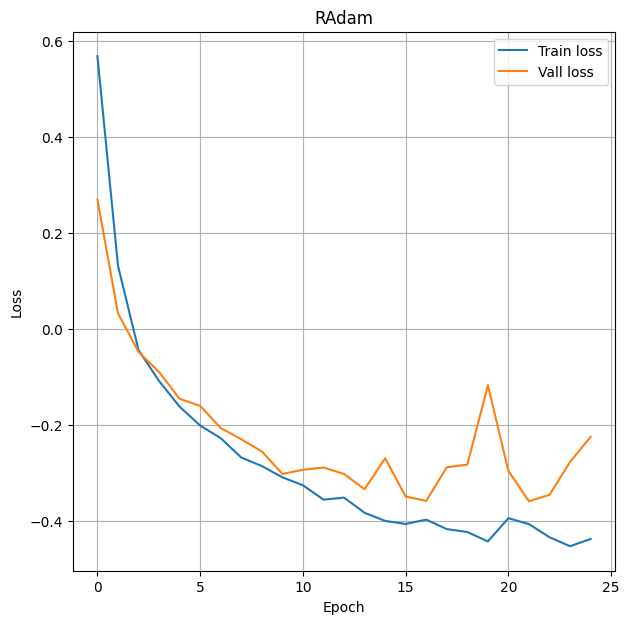

In [92]:
optin_list = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop, 
              torch.optim.Adagrad, torch.optim.NAdam, torch.optim.Adamax,
              torch.optim.AdamW,torch.optim.Adadelta, torch.optim.RAdam]
name_of_the_optim = ['SGD','Adam','Rmsdrop','Adgard','Nesterov_adam',
                     'Adamax', 'AdamW', 'Adadelta', 'RAdam']

for optim, name in zip(optin_list,name_of_the_optim):
    train_loss_history, val_loss_history = history(optim, FeedForward(8, 1).to(device), train_loader, test_loader, num_epoch=25)
    plt.figure(figsize = (7, 7))
    plt.plot(train_loss_history, label = 'Train loss')
    plt.plot(val_loss_history, label = 'Vall loss')
    plt.grid()
    plt.legend()
    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

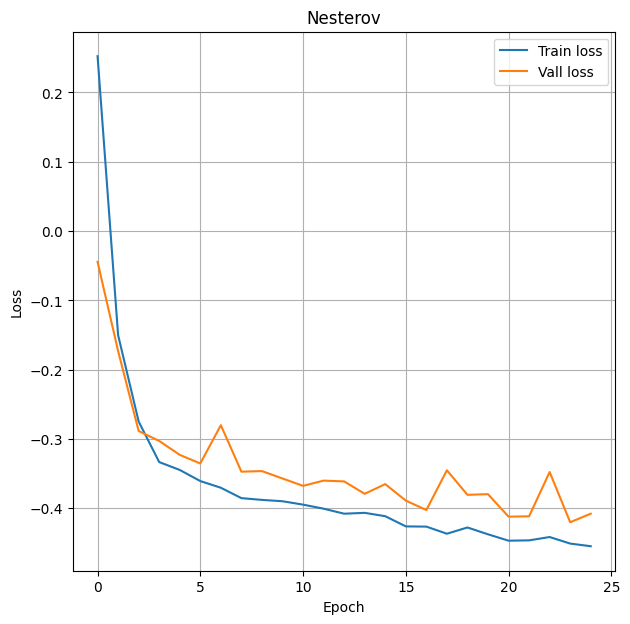

In [93]:
optim = torch.optim.SGD
train_loss_history, val_loss_history = history_2(optim, FeedForward(8, 1).to(device), train_loader, test_loader, mode='Nesterov', num_epoch=25)
plt.figure(figsize = (7, 7))
plt.plot(train_loss_history, label = 'Train loss')
plt.plot(val_loss_history, label = 'Vall loss')
plt.grid()
plt.legend()
plt.title('Nesterov')
plt.xlabel('Epoch')
plt.ylabel('Loss');

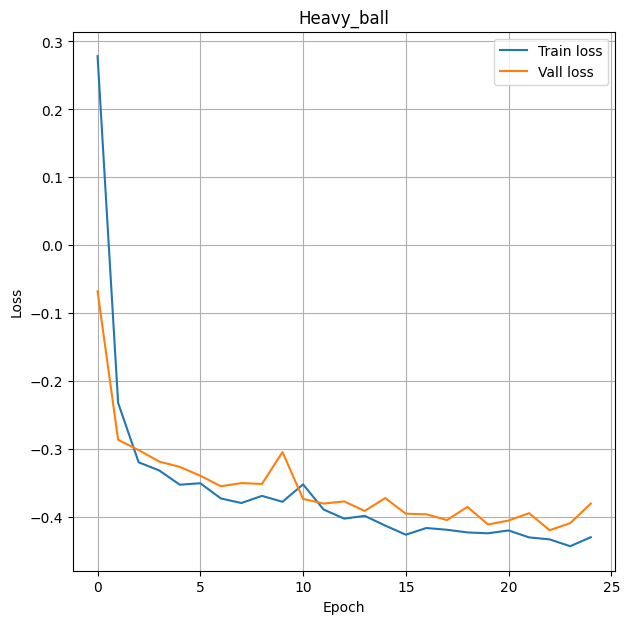

In [94]:
optim = torch.optim.SGD
train_loss_history, val_loss_history = history_2(optim, FeedForward(8, 1).to(device), train_loader, test_loader, mode='Heavy_ball', num_epoch=25)
plt.figure(figsize = (7, 7))
plt.plot(train_loss_history, label = 'Train loss')
plt.plot(val_loss_history, label = 'Vall loss')
plt.grid()
plt.legend()
plt.title('Heavy_ball')
plt.xlabel('Epoch')
plt.ylabel('Loss');

 Хорошие рехультаты показали следующие оптимизаторы
 * Nesterow_Adam Nesterow Heavy ball Rmsdrop, Adam показали наискорейшие спускание к оптимуму на 5 эпохе значение лоса было уже в районе импульсные методы в данной задаче работают эфективней
 * При использовании Heavy ball мы наблюдаем что валидациооная и тестовая выборки двигаюются очень близко друг к другу и отсутсвует переобучение